Сформировать с помощью sklearn.make_classification датасет из 1000 объектов с двумя признаками.
Обучить случайный лес из 1, 3, 10, 50, 100 и 200 деревьев (за основу взять реализацию построения этого алгоритма из урока).
Визуализировать их разделяющие линии на графиках (по подобию визуализации деревьев из предыдущего урока, необходимо только заменить вызов функции predict на tree_vote).
Сделать выводы о получаемой сложности гиперплоскости и недообучении или переобучении случайного леса в зависимости от количества деревьев в нем.

In [476]:
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.colors import ListedColormap
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

In [477]:
classification_data, classification_labels = make_classification(n_samples=1000, n_features=2, n_informative=2, 
                                                                  n_classes=2, n_redundant=0, 
                                                                  n_clusters_per_class=2, flip_y=.1, random_state=1)

In [478]:
def get_visual(classification_data, classification_labels):
  """
  Визуализация сгенерированных данных
  """
  colors = ListedColormap(['red', 'blue'])
  light_colors = ListedColormap(['lightcoral', 'lightblue'])

  plt.figure(figsize=(8,8))
  plt.scatter(classification_data[:, 0], classification_data[:, 1], c=classification_labels, cmap=colors);

  return colors, light_colors

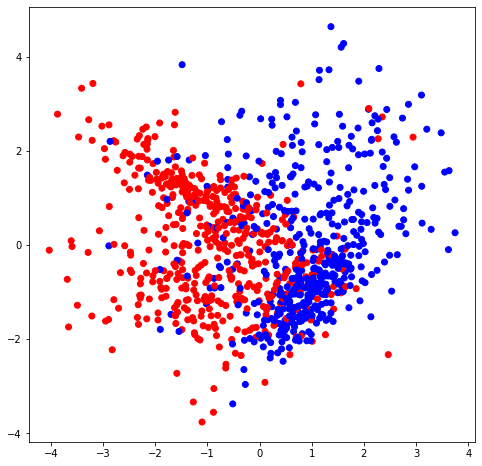

In [479]:
colors, light_colors = get_visual(classification_data, classification_labels)

In [480]:
# np.random.seed(42)

def get_bootstrap(data, labels, N):
  """
  Генерация 𝑁 бутстрап-выборок и подмножества признаков для нахождения разбиения в узле
  """
  n_samples = data.shape[0] # Размер совпадает с исходной выборкой
  bootstrap = []

  for i in range(N):
      
    sample_index = np.random.randint(0, n_samples, size=n_samples)
    b_data = data[sample_index]
    b_labels = labels[sample_index]
    
    bootstrap.append((b_data, b_labels))
      
  return bootstrap

In [481]:
get_bootstrap(classification_data, classification_labels, 2)

[(array([[-0.2360091 , -0.88302353],
         [ 1.29854372, -0.9706828 ],
         [-0.16062248,  0.57864949],
         ...,
         [ 1.90228985, -0.22670526],
         [-1.10693213, -1.40086707],
         [-0.87574011, -0.7104362 ]]),
  array([0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0,
         0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0,
         0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1,
         1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1,
         1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1,
         1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0,
         1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0,
         0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1,
         1, 

In [482]:
def get_subsample(len_sample):
  """
  Будем сохранять не сами признаки, а их индексы
  """
  sample_indexes = list(range(len_sample))
  len_subsample = int(np.round(np.sqrt(len_sample)))   
  subsample = np.random.choice(sample_indexes, size=len_subsample, replace=False)

  return subsample

In [483]:
get_subsample(2)

array([1])

In [484]:
# Класс узла
class Node:
    
  def __init__(self, index, t, true_branch, false_branch):
    self.index = index  # Индекс признака, по которому ведётся сравнение с порогом в этом узле
    self.t = t          # Значение порога
    self.true_branch = true_branch    # Поддерево, удовлетворяющее условию в узле
    self.false_branch = false_branch  # Поддерево, не удовлетворяющее условию в узле

In [485]:
# Класс листа
class Leaf:
    
  def __init__(self, data, labels):
    self.data = data
    self.labels = labels
    self.prediction = self.predict()
        
  def predict(self):
    # Подсчёт количества объектов разных классов
    classes = {}  # "класс: количество объектов"
    for label in self.labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
        
    # Найдём класс, количество объектов которого будет максимальным в этом листе и вернём его    
    prediction = max(classes, key=classes.get)
    return prediction   

In [486]:
def get_gini(labels):
  """
  Расчёт критерия Джини
  """
  #  Подсчёт количества объектов разных классов
  classes = {}

  for label in labels:
    if label not in classes:
        classes[label] = 0
    classes[label] += 1
  
  #  Расчёт критерия
  impurity = 1
  for label in classes:
    p = classes[label] / len(labels)
    impurity -= p ** 2
      
  return impurity

In [487]:
def get_gain(left_labels, right_labels, root_gini):
  """
  Расчёт прироста
  """

  # Доля выборки, ушедшая в левое поддерево
  p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
  
  return root_gini - p * get_gini(left_labels) - (1 - p) * get_gini(right_labels)

In [488]:
def split(data, labels, column_index, t):
  """
  Разбиение датасета в узле
  """
    
  left = np.where(data[:, column_index] <= t)
  right = np.where(data[:, column_index] > t)
      
  true_data = data[left]
  false_data = data[right]
  
  true_labels = labels[left]
  false_labels = labels[right]
      
  return true_data, false_data, true_labels, false_labels

In [489]:
def find_best_split(data, labels):
  """
  Нахождение наилучшего разбиения
  """
  # min_leaf_samples = 5

  root_gini = get_gini(labels)

  best_gain = 0
  best_t = None
  best_index = None
  
  n_features = data.shape[1]
  
  feature_subsample_indices = get_subsample(n_features) # Выбираем случайные признаки
  
  for index in feature_subsample_indices:
    # Будем проверять только уникальные значения признака, исключая повторения
    t_values = np.unique(data[:, index])
    
    for t in t_values:
      true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
      #  Пропускаем разбиения, в которых в узле остаётся менее 5 объектов
#             if len(true_data) < min_leaf_samples or len(false_data) < min_leaf_samples:
#                 continue
      
      current_gain = get_gain(true_labels, false_labels, root_gini)
      
      # Выбираем порог, на котором получается максимальный прирост качества
      if current_gain > best_gain:
         best_gain, best_t, best_index = current_gain, t, index

  return best_gain, best_t, best_index

In [490]:
def build_tree(data, labels):
  """
  Функция рекурсивного построения дерева
  """
  gain, t, index = find_best_split(data, labels)

  # Прекращаем рекурсию, когда нет прироста в качества
  if gain == 0:
    return Leaf(data, labels)

  true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

  # Рекурсивно строим два поддерева
  true_branch = build_tree(true_data, true_labels)
  false_branch = build_tree(false_data, false_labels)

  # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
  return Node(index, t, true_branch, false_branch)

In [491]:
def random_forest(data, labels, n_trees):
  """
  Функция формирования случайного леса
  """
  forest = []
  bootstrap = get_bootstrap(data, labels, n_trees)
  
  for b_data, b_labels in bootstrap:
    forest.append(build_tree(b_data, b_labels))
      
  return forest

In [492]:
def classify_object(obj, node):
  """
  Функция классификации отдельного объекта
  """
  # Если достигли листа
  if isinstance(node, Leaf):
    answer = node.prediction
    return answer

  if obj[node.index] <= node.t:
    return classify_object(obj, node.true_branch)
  else:
    return classify_object(obj, node.false_branch)

In [493]:
def predict(data, tree):
  """
  функция формирования предсказания по выборке на одном дереве
  """
    
  classes = []
  for obj in data:
    prediction = classify_object(obj, tree)
    classes.append(prediction)
  return classes

In [494]:
def tree_vote(forest, data):
  """
  Функция предсказания голосованием деревьев
  """

  # Добавим предсказания всех деревьев в список
  predictions = []
  for tree in forest:
    predictions.append(predict(data, tree))
#     print(predictions)

  # Сформируем список с предсказаниями для каждого объекта
  predictions_per_object = list(zip(*predictions))
#     print(predictions_per_object)

  # Выберем в качестве итогового предсказания для каждого объекта то,
  # за которое проголосовало большинство деревьев
  voted_predictions = []
  for obj in predictions_per_object:
    voted_predictions.append(max(set(obj), key=obj.count))
      
  return voted_predictions

In [495]:
train_data, test_data, train_labels, test_labels = train_test_split(classification_data, 
                                                                    classification_labels, 
                                                                    test_size=0.3,
                                                                    random_state=1)

In [496]:
def accuracy_metric(actual, predicted):
  """
  Функция подсчёта доли правильных ответов
  """
  correct = 0
  for i in range(len(actual)):
    if actual[i] == predicted[i]:
      correct += 1
  return correct / float(len(actual)) * 100.0

In [497]:
def my_forest(train_data, train_labels, test_labels, n_trees):
  """
  Построение леса из n_trees деревьев
  """

  forest = random_forest(train_data, train_labels, n_trees)

  # Получим ответы для обучающей выборки 
  train_answers = tree_vote(forest, train_data)

  # И получим ответы для тестовой выборки
  test_answers = tree_vote(forest, test_data)

  # Точность на обучающей выборке
  train_accuracy = accuracy_metric(train_labels, train_answers)
  print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy:.3f}')

  # Точность на тестовой выборке
  test_accuracy = accuracy_metric(test_labels, test_answers)
  print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy:.3f}\n')

  return forest, train_accuracy, test_accuracy

In [498]:
# Визуализируем дерево на графике
def get_meshgrid(data, step=.05, border=1.2):

  x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
  y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
  
  return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

In [499]:
def visualize(train_data, test_data, forest):
    plt.figure(figsize = (16, 7))

    # График обучающей выборки
    plt.subplot(1,2,1)
    xx, yy = get_meshgrid(train_data)
    mesh_predictions = np.array(tree_vote(forest, np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape) # С этой строкой кода я "залип" на 2 часа!!!
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
    plt.title(f'Train accuracy={train_accuracy:.2f}')

    # График тестовой выборки
    plt.subplot(1,2,2)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
    plt.title(f'Test accuracy={test_accuracy:.2f}')

In [500]:
%%time
forest, train_accuracy, test_accuracy = my_forest(train_data, train_labels, test_labels, n_trees=1)

Точность случайного леса из 1 деревьев на обучающей выборке: 92.143
Точность случайного леса из 1 деревьев на тестовой выборке: 77.000

CPU times: user 350 ms, sys: 2.87 ms, total: 353 ms
Wall time: 360 ms


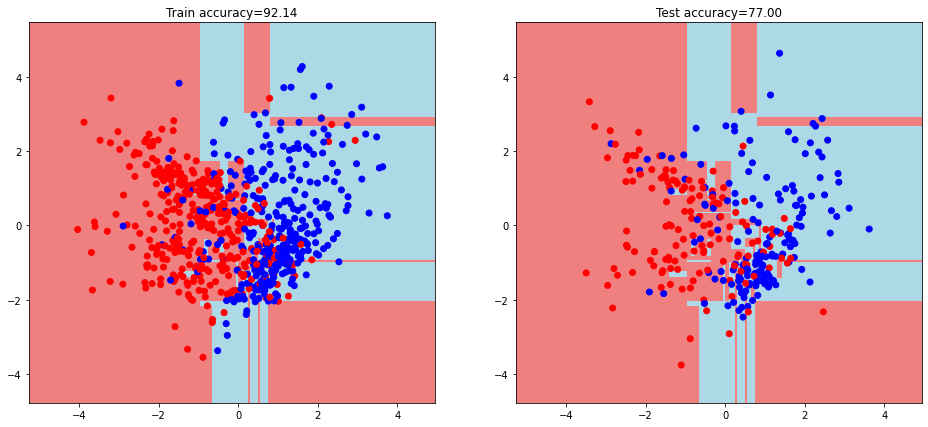

In [501]:
visualize(train_data, test_data, forest)

In [502]:
%%time
forest, train_accuracy, test_accuracy = my_forest(train_data, train_labels, test_labels, n_trees=3)

Точность случайного леса из 3 деревьев на обучающей выборке: 94.714
Точность случайного леса из 3 деревьев на тестовой выборке: 76.333

CPU times: user 2.03 s, sys: 7.29 ms, total: 2.03 s
Wall time: 2.18 s


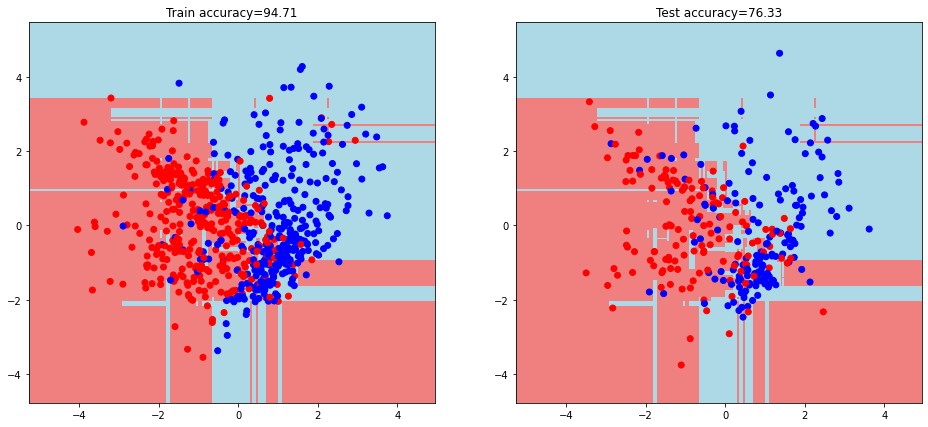

In [503]:
visualize(train_data, test_data, forest)

In [504]:
%%time
forest, train_accuracy, test_accuracy = my_forest(train_data, train_labels, test_labels, n_trees=10)

Точность случайного леса из 10 деревьев на обучающей выборке: 98.857
Точность случайного леса из 10 деревьев на тестовой выборке: 77.000

CPU times: user 3.4 s, sys: 17.7 ms, total: 3.42 s
Wall time: 3.43 s


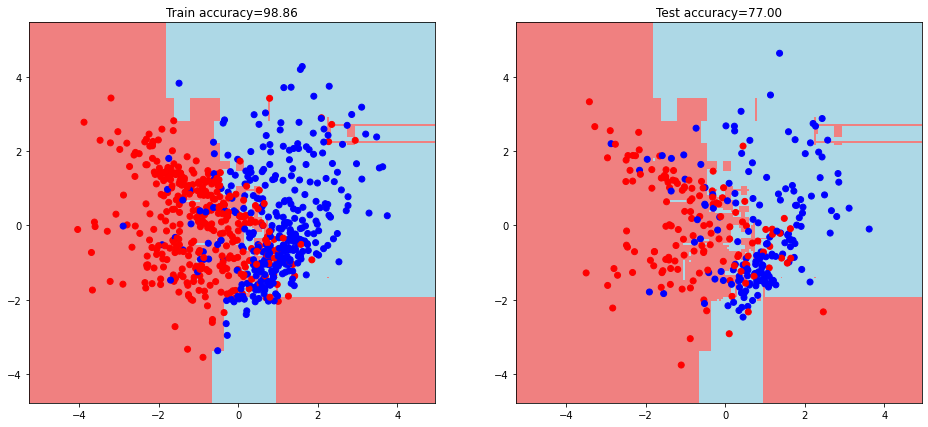

In [505]:
visualize(train_data, test_data, forest)

In [468]:
%%time
forest, train_accuracy, test_accuracy = my_forest(train_data, train_labels, test_labels, n_trees=50)

Точность случайного леса из 50 деревьев на обучающей выборке: 100.000
Точность случайного леса из 50 деревьев на тестовой выборке: 80.333

CPU times: user 21 s, sys: 82.7 ms, total: 21.1 s
Wall time: 21.3 s


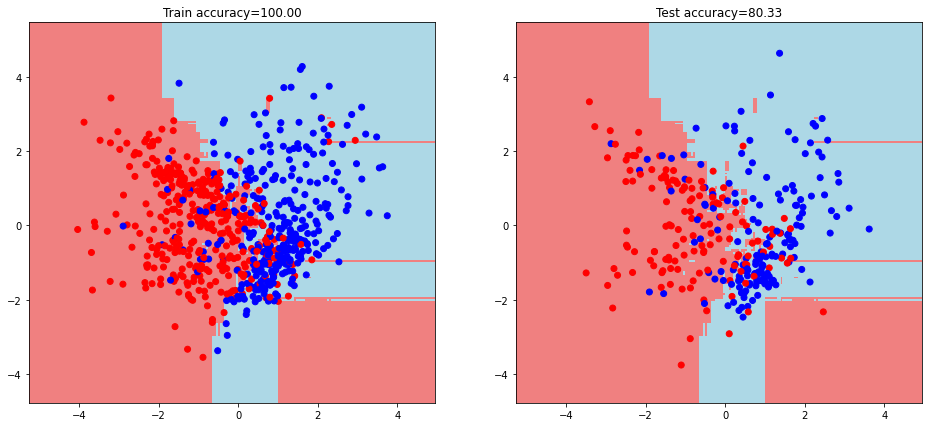

In [469]:
visualize(train_data, test_data, forest)

In [470]:
%%time
forest, train_accuracy, test_accuracy = my_forest(train_data, train_labels, test_labels, n_trees=100)

Точность случайного леса из 100 деревьев на обучающей выборке: 99.857
Точность случайного леса из 100 деревьев на тестовой выборке: 79.000

CPU times: user 38.6 s, sys: 121 ms, total: 38.7 s
Wall time: 38.9 s


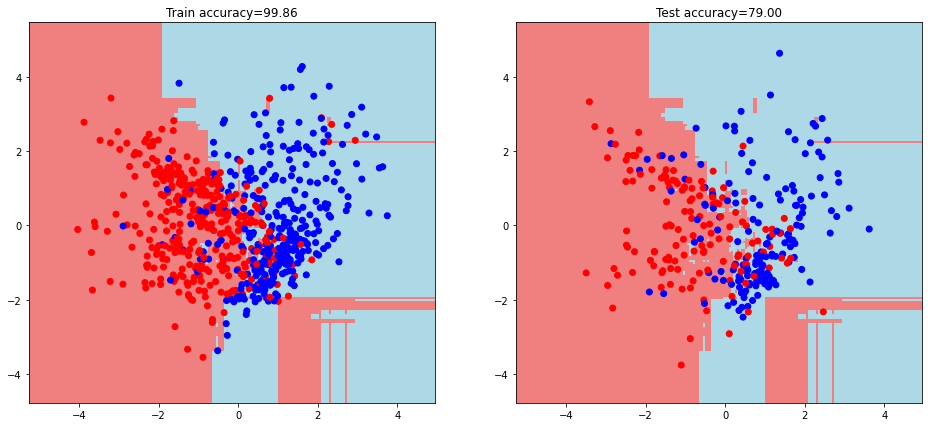

In [471]:
visualize(train_data, test_data, forest)

In [472]:
%%time
forest, train_accuracy, test_accuracy = my_forest(train_data, train_labels, test_labels, n_trees=200)

Точность случайного леса из 200 деревьев на обучающей выборке: 100.000
Точность случайного леса из 200 деревьев на тестовой выборке: 79.333

CPU times: user 1min 18s, sys: 221 ms, total: 1min 18s
Wall time: 1min 19s


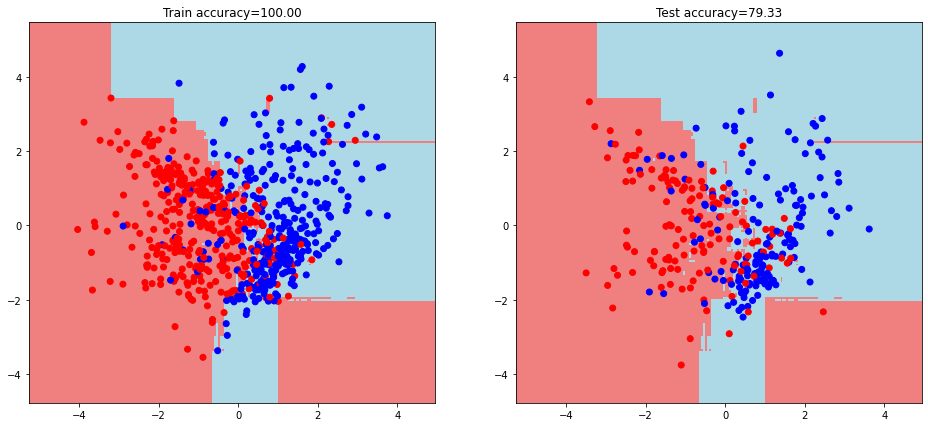

In [473]:
visualize(train_data, test_data, forest)

Вывод, при числе деревьев равным 50, метрики показывают хорошее обучение, хороший результат на тесте, но если число деревьев увеличивать, то модель переобучается и начиная с числа в деревьев 200 на тесте результаты еще хуже. Оптимум - примерно 50 деревьев.